In [3]:
import torch
import torch.nn.functional as F
from task.TaskGenerator import GaussianTaskGenerator
import matplotlib.pyplot as plt

# Task setting
Define the task family and the possible priors on the parameters for meta-training the model

In [4]:
# Problem param
z_dim = 2
n_tasks = 1000

# Input space range
x_min = -100
x_max = 100

# Training task latent space range
min_mean = -40
max_mean = 40

min_std = 15
max_std = 35

# Prior on the offset task range
mu_min = -10
mu_max = 10

var_min = 0.1
var_max = 5

# Task generator creation
task_gen = GaussianTaskGenerator(x_min=x_min, x_max=x_max)

# Data creation
def sample_task(n_batches=10, test_perc=0, batch_size=128):
    #a = (min_a - max_a) * torch.rand(1) + max_a
    a = 1
    m = (min_mean - max_mean) * torch.rand(1) + max_mean
    s = (min_std - max_std) * torch.rand(1) + max_std
    
    data = task_gen.get_mixed_data_loader(amplitude=a, 
                                    mean=m,
                                    std=s,
                                    num_batches=n_batches,
                                    test_perc=test_perc, 
                                    batch_size=batch_size)
    return data, m, s

def sample_prior_dist(dim):
    mu_l = []
    var_l = []
    for i in range(dim):
        mu = (mu_min - mu_max) * torch.rand(1) + mu_max
        var = (var_min - var_max) * torch.rand(1) + var_max
        
        mu_l.append(mu)
        var_l.append(var)
    
    return mu_l, var_l
    
# Dataset creation
data_set = []
a_set = []
mean_set = []
std_set = []
param = []
for _ in range(n_tasks):
    data, mean, std = sample_task(n_batches=1, test_perc=0, batch_size=180)
    data_set.append(data)
    mean_set.append(mean)
    std_set.append(std)
    param.append((mean.item(), std.item()))
    
# Prior distribution on the next task
prior_dist = []
for _ in range(n_tasks):
    prior_dist.append(torch.Tensor(sample_prior_dist(z_dim)))

In [5]:
m = 0
for i in range(n_tasks):
    t = torch.abs(prior_dist[i][0]).max()
    if t > m:
        m = t
m

tensor(9.9926)

In [4]:
# Print some offset according to this procedure
for _ in range(10):
    t_idx = torch.randint(0, 1000, size=(1,))
    mu = prior_dist[t_idx][0]
    var = prior_dist[t_idx][1]
    print("Offset {} || Offset - mu {} || Prior {}".format(torch.normal(mu, var), 
                                               (torch.normal(mu, var)-prior_dist[t_idx][0]),
                                                          prior_dist[t_idx][1]))

Offset tensor([-10.9185,   9.5991]) || Offset - mu tensor([-7.6972, -1.5370]) || Prior tensor([4.1347, 2.8275])
Offset tensor([1.9161, 3.9975]) || Offset - mu tensor([0.9649, 1.8080]) || Prior tensor([1.5667, 3.1941])
Offset tensor([ 6.2699, -4.1125]) || Offset - mu tensor([-3.9101,  0.0651]) || Prior tensor([1.9943, 2.4546])
Offset tensor([-9.4966, -9.7642]) || Offset - mu tensor([ 4.0148, -0.0294]) || Prior tensor([3.8986, 0.1956])
Offset tensor([-8.4305, -1.0425]) || Offset - mu tensor([1.0025, 2.8100]) || Prior tensor([1.7328, 4.6978])
Offset tensor([-7.8104,  2.6887]) || Offset - mu tensor([ 1.8622, -0.5784]) || Prior tensor([4.5679, 1.5789])
Offset tensor([ 8.7084, -2.3953]) || Offset - mu tensor([0.3101, 0.4836]) || Prior tensor([2.2389, 1.2614])
Offset tensor([8.9754, 1.0343]) || Offset - mu tensor([2.7203, 0.7696]) || Prior tensor([4.3161, 4.2136])
Offset tensor([0.6334, 8.5774]) || Offset - mu tensor([-0.1942,  9.4305]) || Prior tensor([0.8271, 4.5812])
Offset tensor([ -7.426

In [15]:
import numpy as np
t = []
t2 = []
for i in range(n_tasks):
    t.append(prior_dist[i][0][0])
    t2.append(prior_dist[i][0][1])
print(np.mean(t))
print(np.mean(t2))

-0.053610373
0.20893787


# Inference network

In [8]:
# Define the network for inference on the latent space
class InferenceNetwork(torch.nn.Module):
    """
    Input:
        Previous latent space 
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)
    
    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """
    def __init__(self, n_in, z_dim):
        super(InferenceNetwork, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in
        
        self.enc1 = torch.nn.Linear(n_in, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=32, num_layers=2, batch_first=True)
        self.enc3 = torch.nn.Linear(32, 16)
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)
        
    def encode(self, context, prev_z, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        
        # Data preparation
        prev_z = prev_z.reshape(n_batch, 1, 2)
        prev_z = prev_z.repeat(1, seq_len, 1)
        
        prior = prior.reshape(n_batch, 1, 4)
        prior = prior.repeat(1, seq_len, 1)
        
        context = torch.cat([context, prev_z, prior], dim=2) 
        
        # Data processing
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        if use_prev_state:
            t, self.h = self.enc2(t, self.h)
        else:
            t, self.h = self.enc2(t)
        t = t[:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)
        t = F.elu(self.enc3(t))
        
        # Return encoded mu and logvar
        return  self.enc41(t), self.enc42(t)
        
    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z, prior, use_prev_state=False):
        mu, logvar = self.encode(context, prev_z, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar

    
    
# Define the network for inference on the latent space
class InferenceNetwork2(torch.nn.Module):
    """
    Input:
        Previous latent space 
        sequence of data from the current task and old task at that point
        prior over the current task (expressed as vector mu and c)
    
    Output:
        - sample from the probability distribution over the latent space
        - mu and logvar from the posterior distribution
    """
    def __init__(self, n_in, z_dim):
        super(InferenceNetwork2, self).__init__()
        self.z_dim = z_dim
        self.n_in = n_in
        
        self.enc1 = torch.nn.Linear(n_in, 32) # 3 input: x, f_t(x), f_(t-1)(x)
        self.enc2 = torch.nn.GRU(input_size=32, hidden_size=32, num_layers=2, batch_first=True)
        self.enc3 = torch.nn.Linear(32+z_dim*2+1, 16) # hidden + the prior + seq_len 
        self.enc41 = torch.nn.Linear(16, z_dim)
        self.enc42 = torch.nn.Linear(16, z_dim)
        
        self.h = None
        self.seq_len = 0
        
    def encode(self, context, prev_z, prior, use_prev_state):
        # Compute batch number and lenght of the sequence
        n_batch = context.shape[0]
        seq_len = context.shape[1]
        
        # Data preparation
        prev_z = prev_z.reshape(n_batch, 1, 2)
        prev_z = prev_z.repeat(1, seq_len, 1)
        
        original_prior = prior
        if len(original_prior.shape) == 1:
            original_prior = original_prior.unsqueeze(0)
        prior = prior.reshape(n_batch, 1, 4)
        prior = prior.repeat(1, seq_len, 1)
        
        context = torch.cat([context, prev_z, prior], dim=2) 
        
        # Data processing
        t = F.elu(self.enc1(context)).view(n_batch, seq_len, 32)
        if use_prev_state and self.h is not None:
            t, self.h = self.enc2(t, self.h)
        else:
            t, self.h = self.enc2(t)
        t = t[:, -1, :] # we are interested only in the last output of the sequence
        t = F.elu(t)

        self.seq_len += seq_len 
        trust = torch.tensor([self.seq_len], dtype=t.dtype).repeat(n_batch, 1)
        t = torch.cat([t, original_prior, trust], 1)
        t = F.elu(self.enc3(t))
        
        
        # Return encoded mu and logvar
        return  self.enc41(t), self.enc42(t)
        
    def reparameterize(self, mu, logvar):
        # Re-parametrization trick
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std
    
    def forward(self, context, prev_z, prior, use_prev_state=False):
        if not use_prev_state:
            self.h = None
            self.seq_len = 0
        
        mu, logvar = self.encode(context, prev_z, prior, use_prev_state)
        z = self.reparameterize(mu=mu, logvar=logvar)
        return z, mu, logvar


In [6]:
# Define the loss function 
kld_list = []
mse_list = []

def loss_inference_closed_form(z, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch):
    MSE = torch.mean(torch.sum(logvar_hat.exp(), 1)) + F.mse_loss(mu_hat, z)
    
    KLD_1 = (torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))
    KLD_2 = (torch.sum(-1+(mu_hat - mu_prior).pow(2) * (1/logvar_prior.exp()) + (logvar_hat.exp()*(1/logvar_prior.exp())), 1))
    
    KLD = (1/2) * torch.mean(KLD_1 + KLD_2)
    
    kld_list.append(KLD.item())
    mse_list.append(MSE.item())
    if epoch % 100 == 0:
        print("MSE {}".format(MSE.item()))
        print("KLD {}".format(KLD.item()))
    
    return MSE + KLD
    
def loss_inference_sampling(z_hat, z, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch):
    # KLD derived from two multivariate gaussian exploiting diagonal properties
    MSE = F.mse_loss(z_hat, z)
    
    KLD_1 = (torch.log(torch.prod(logvar_prior.exp(), 1) / torch.prod(logvar_hat.exp(), 1)))
    KLD_2 = (torch.sum(-1+(mu_hat - mu_prior).pow(2) * (1/logvar_prior.exp()) + (logvar_hat.exp()*(1/logvar_prior.exp())), 1))
    
    KLD = (1/2) * torch.mean(KLD_1 + KLD_2)
    
    kld_list.append(KLD.item())
    mse_list.append(MSE.item())
    if epoch % 100 == 0:
        print("MSE {}".format(MSE.item()))
        print("KLD {}".format(KLD.item()))
    
    return MSE + KLD


In [620]:
# Define the training procedure
min_seq_len = 1
max_seq_len = 150

def train_inference_network(epoch, batch_per_task=1, n_batch=32):
    train_loss = 0
    
    # Choose pair of init task and distribution for the next task
    task_idx = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    task_loader = [data_set[i] for i in task_idx]
    target = torch.tensor([param[i] for i in task_idx])
    
    prev_task_param = torch.randint(low=0, high=n_tasks, size=(n_batch,))
    
    prior = torch.empty(n_batch, 4)
    mu_prior = torch.empty(n_batch, 2)
    logvar_prior = torch.empty(n_batch, 2)
    for t_idx in range(n_batch):
        prior[t_idx] = prior_dist[prev_task_param[t_idx]].reshape(1, 4).squeeze(0).clone().detach()
        mu_prior[t_idx] = prior_dist[prev_task_param[t_idx]][0].clone().detach()
        logvar_prior[t_idx] = prior_dist[prev_task_param[t_idx]][1].clone().detach().log()
    
    for k in range(batch_per_task):
        num_data_context = torch.randint(low=min_seq_len, high=max_seq_len, size=(1,)).item()
        idx = torch.randperm(max_seq_len)
        ctx_idx = idx[0:num_data_context]
        
        context = torch.empty(n_batch, num_data_context, 2)
        prev_task = torch.empty(n_batch, 2)

        # Retrieving data to be fed to the network 
        i = 0
        for t_idx, task in enumerate(task_loader):
            # Creating new task
            mu = prior_dist[prev_task_param[t_idx]][0].clone().detach()
            var = prior_dist[prev_task_param[t_idx]][1].clone().detach()
            
            offset_param = torch.normal(mu, var)
            prev_task[i] = target[i] - offset_param 
            prior[i][0:2] = prev_task[i] + prior[i][0:2].clone().detach()
            mu_prior[i] = prev_task[i] + mu_prior[i].clone().detach()
            
            # Creating context to be fed to the network 
            batch = task[k]['train']
            batch = torch.cat([batch[0], batch[1]], dim=1)
            batch[ctx_idx]
            context[i] = batch[ctx_idx]
            i+=1

        optimizer.zero_grad()
        z_hat, mu_hat, logvar_hat = inference_net(context, prev_task, prior)

        # Compute reconstruction
        loss = loss_inference_closed_form(target, mu_hat, logvar_hat, mu_prior, logvar_prior, epoch)
        loss.backward()

        train_loss += loss.item()
        optimizer.step()
    
    return train_loss / (batch_per_task)




In [619]:
inference_net = InferenceNetwork2(n_in=8,z_dim=2)
optimizer = torch.optim.Adam(inference_net.parameters())

In [621]:
n_epochs = 100000
losses = []
l_sum = 0
for i in range(n_epochs):
    l = train_inference_network(i)
    l_sum += l
    losses.append(l)
    if i % 100 == 0:
        print('====> Epoch: {} Average loss: {:.4f}'.format(i, l_sum/(i+1)))
        
#torch.save(inference_net, "inference_mixed")

tensor([[ 1.4811,  1.2372],
        [-0.0064,  1.5069],
        [-0.9446, -0.4740],
        [ 1.3835,  0.2613],
        [ 1.3520,  0.2849],
        [ 0.6717, -1.6588],
        [ 0.2607,  0.9075],
        [ 0.8153,  1.5107],
        [ 1.2165, -1.0403],
        [ 0.5820, -0.0695],
        [-1.2962,  1.4516],
        [ 1.3493,  1.2623],
        [ 0.4963,  0.9370],
        [ 0.8002,  1.5454],
        [ 1.5916,  0.4590],
        [ 1.0075,  1.3770],
        [ 0.7750,  1.2710],
        [ 0.7446, -0.8435],
        [ 0.7494,  1.5665],
        [ 1.1520,  0.6196],
        [ 0.1663,  1.3797],
        [ 0.8722, -0.4882],
        [ 0.1720,  1.1032],
        [ 1.2540,  1.1848],
        [ 1.2065,  0.0027],
        [ 0.1065,  1.2421],
        [-0.0436,  0.8036],
        [ 1.4619,  1.2089],
        [ 0.7750,  1.2710],
        [ 0.9234,  1.2109],
        [ 0.8265,  0.3820],
        [ 0.8722, -0.4882]])
MSE 762.54052734375
KLD 548.392578125
====> Epoch: 0 Average loss: 1310.9331
tensor([[ 1.3552e+00,  7.4

tensor([[-1.0535,  0.3598],
        [ 0.2861, -2.1470],
        [ 0.6621,  1.5113],
        [ 0.8158,  0.3396],
        [ 0.7974, -0.5354],
        [ 1.1768, -0.2274],
        [ 0.8855,  1.0964],
        [ 0.9137,  0.8906],
        [-0.2696,  1.2181],
        [ 1.0487,  0.9466],
        [ 1.0260, -1.2875],
        [ 0.5737,  1.0805],
        [ 0.9612, -0.2088],
        [ 1.0342,  1.3918],
        [ 1.1530,  1.5157],
        [ 1.5419,  1.5316],
        [ 0.9286,  0.2146],
        [ 1.5829,  0.8980],
        [ 0.9647,  0.6328],
        [ 1.4768, -0.1290],
        [ 0.9677,  1.1054],
        [ 1.4929,  1.5802],
        [ 1.5182,  1.4680],
        [ 1.4505,  1.3753],
        [-1.5180,  1.1165],
        [ 0.4036,  0.7956],
        [-1.5286, -0.4794],
        [-0.1924, -0.0630],
        [ 1.3263,  0.4206],
        [-1.1573, -0.2944],
        [ 0.6066, -0.2189],
        [ 1.2813,  1.4224]])
tensor([[ 4.1561e-01,  1.4704e-03],
        [-3.6497e-03,  1.1956e+00],
        [ 9.8858e-01,  1.2120e+

tensor([[ 1.3184,  1.1016],
        [ 1.5643,  1.1404],
        [ 0.7304, -0.3402],
        [ 1.3835,  0.2613],
        [-1.9967,  1.0665],
        [ 0.1004,  0.8575],
        [ 1.1052,  0.5177],
        [ 0.9857,  1.5676],
        [ 1.4829,  1.5842],
        [ 0.6132,  1.2209],
        [ 1.2904,  1.2284],
        [ 1.0081,  1.5577],
        [-0.0064,  1.5069],
        [ 0.5298, -0.9998],
        [ 1.5541, -0.0216],
        [-1.1434, -0.6706],
        [ 0.8898,  1.6085],
        [ 0.8791, -0.6133],
        [ 0.1097,  0.2982],
        [ 0.7304, -0.3402],
        [ 1.2776,  1.1742],
        [-0.8112,  1.0864],
        [ 1.5846,  1.4890],
        [ 1.2593,  0.4926],
        [ 0.9346,  0.9819],
        [-0.0421,  0.1352],
        [ 1.4195,  0.8918],
        [-0.2690,  1.4455],
        [ 1.5781,  1.3166],
        [ 1.4756,  0.4316],
        [ 0.5742,  1.5061],
        [ 1.2882,  1.4415]])
tensor([[ 1.0002,  1.4509],
        [-0.0814,  0.1444],
        [ 0.4711,  1.3709],
        [ 1.0137,  

tensor([[ 0.4666,  0.9324],
        [ 0.6849,  1.5222],
        [ 1.1085,  1.4093],
        [ 1.5236,  1.1808],
        [-1.4179,  1.0577],
        [-1.7273,  1.3724],
        [ 0.4089, -0.2256],
        [ 1.4913,  0.2225],
        [ 1.1534,  0.9086],
        [ 0.6732,  1.1375],
        [ 1.3148,  1.3440],
        [ 0.9165,  0.6497],
        [-0.1064,  1.5406],
        [ 0.7688,  1.0324],
        [ 0.8846,  1.2746],
        [ 1.1052,  0.5177],
        [ 1.3520,  0.2849],
        [ 1.4160, -0.7153],
        [ 1.4195,  0.8918],
        [-1.1434, -0.6706],
        [ 1.5825, -0.1278],
        [-0.5630, -0.8932],
        [-0.0799,  1.4686],
        [ 0.6195, -1.4112],
        [ 0.3740, -1.9097],
        [ 0.0814,  1.3335],
        [ 0.4785,  1.1866],
        [ 1.3600,  0.8417],
        [ 1.0236,  1.0576],
        [-0.9675,  1.6092],
        [ 1.5082,  1.2116],
        [ 0.2687,  1.5418]])
tensor([[-0.4632,  0.8927],
        [ 1.2776,  1.1742],
        [ 0.2782,  1.3346],
        [ 1.4733,  

tensor([[-0.9574, -1.4086],
        [ 0.9394, -1.5469],
        [ 0.8002,  1.5454],
        [-1.0329, -0.0902],
        [ 0.8715,  1.0650],
        [-1.4179,  1.0577],
        [ 1.2025,  1.5731],
        [ 1.2816,  1.5973],
        [-0.2690,  1.4455],
        [ 1.3835,  0.2613],
        [ 1.5153,  0.2697],
        [ 1.1085,  1.4093],
        [ 1.4181, -0.1531],
        [ 1.5236,  1.1808],
        [ 0.6248,  0.6197],
        [ 1.4832,  0.9720],
        [-0.4641,  1.1458],
        [ 1.1846,  1.0896],
        [-0.2883,  1.0789],
        [ 1.1279,  1.5276],
        [ 1.4798, -1.0361],
        [-1.9132,  1.5829],
        [-0.2918,  0.6516],
        [ 0.2704,  1.2737],
        [ 0.3740, -1.9097],
        [ 0.6717, -1.6588],
        [ 0.3277, -0.4006],
        [ 1.6043,  1.4477],
        [ 0.1953, -0.5296],
        [ 0.4149, -0.4413],
        [ 0.5754, -0.0127],
        [ 1.3785,  1.2512]])
tensor([[-0.3524,  0.9085],
        [-0.4110,  1.0032],
        [ 0.6732,  1.1375],
        [ 1.4089,  

tensor([[-9.3441e-01,  7.5411e-01],
        [ 1.4036e+00,  9.9759e-01],
        [ 1.5678e+00,  3.2048e-01],
        [ 1.4692e+00,  1.3999e+00],
        [ 8.2597e-01,  4.5431e-01],
        [ 1.4499e+00,  1.2437e+00],
        [-4.0297e-02,  1.4553e+00],
        [ 1.5438e+00, -1.4783e-04],
        [ 1.1520e+00,  6.1959e-01],
        [ 1.4071e+00, -1.0142e-01],
        [ 1.4499e+00,  1.2437e+00],
        [ 1.5576e+00,  6.3993e-01],
        [ 1.0096e+00,  1.5168e+00],
        [ 1.5981e+00, -6.2132e-01],
        [ 1.2205e+00, -3.6307e-01],
        [ 4.0282e-01,  6.3487e-01],
        [ 1.3737e+00,  1.1799e+00],
        [ 1.5348e+00,  1.4368e+00],
        [ 1.3953e+00,  1.3418e+00],
        [-2.3870e-01,  9.1780e-01],
        [ 1.3559e+00, -1.2347e+00],
        [ 1.4011e+00,  1.2062e+00],
        [ 1.4725e+00,  1.4408e+00],
        [ 1.2248e+00, -1.3209e+00],
        [ 4.1493e-01, -4.4129e-01],
        [ 1.5781e+00,  1.3166e+00],
        [ 1.4306e+00,  1.5024e+00],
        [ 9.1144e-01,  5.025

KeyboardInterrupt: 

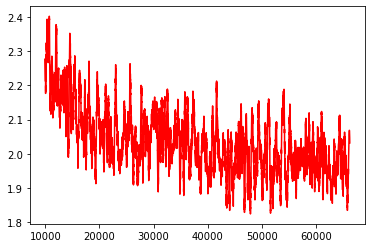

In [48]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(mse_list)
x = np.arange(len(y))
yhat = savgol_filter(y,501, 3) 

plt.plot(x[10000:], yhat[10000:], color='red')
plt.show()

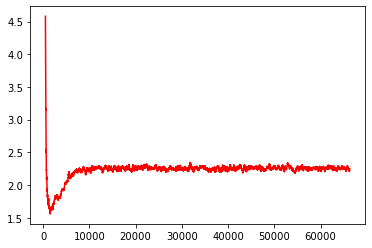

In [17]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(kld_list)
x = np.arange(len(y))
yhat = savgol_filter(y,501, 3) 

plt.plot(x[500:], yhat[500:], color='red')
plt.show()

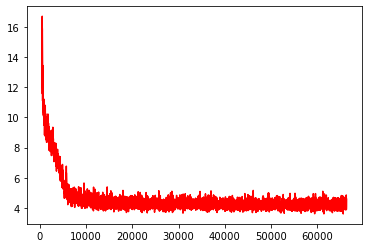

In [18]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(losses)
x = np.arange(len(y))
yhat = savgol_filter(y,51, 3) 

plt.plot(x[500:], yhat[500:], color='red')
plt.show()

In [19]:
torch.save(inference_net, "inference_2")

C:\Users\Riccardo\Anaconda3\envs\sequential-transfer-rl\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type InferenceNetwork2. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Multi-task learning optimal policy

In [6]:
import gym
import gym_sin
import numpy as np
import time
from collections import deque
from gym import spaces


from ppo_a2c.model import Policy, MLPBase, ImprovedMLPBase
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.storage import RolloutStorage
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.utils import get_vec_normalize

In [91]:
# General parameters
device = "cpu"
env_name = "gauss-v0"
seed = 0
gamma = None
log_dir = "."

# Training parameters
num_steps_multi_task = 150
num_processes = 32

# PPO parametrs
clip_param_multi_task = 0.2
ppo_epoch_multi_task = 4
num_mini_batch_multi_task = 8
value_loss_coef_multi_task = 0.5
entropy_coef_multi_task = 0.0
lr_multi_task = 0.0001
eps_multi_task = 1e-6
max_grad_norm_multi_task = 0.5

# Training parameters
use_linear_lr_decay = False
use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False
log_interval = 100
eval_interval = 1

In [92]:
base_multi_task = MLPBase
obs_shape_multi_task = (2,) # state + latent space of the current model
action_space_multi_task = spaces.Box(low=np.array([-1]), high=np.array([1]))
actor_critic_multi_task = Policy(obs_shape_multi_task,
                                 action_space_multi_task, base=base_multi_task,
                                 base_kwargs={'recurrent': False,'hidden_size':16,'use_elu':True})

agent_multi_task = PPO(actor_critic_multi_task,
          clip_param_multi_task,
          ppo_epoch_multi_task,
          num_mini_batch_multi_task,
          value_loss_coef_multi_task,
          entropy_coef_multi_task,
          lr=lr_multi_task,
          eps=eps_multi_task,
          max_grad_norm=max_grad_norm_multi_task,
          use_clipped_value_loss=True)

episode_rewards = deque(maxlen=10)

In [93]:
def augment_obs(latent, latent_dim, num_proc):
    """
    Augment observation with the latent space
    
    Input
    - obs: observation from the environment (shape: (num_proc, env_obs_shape))
    - latent: list of tuples of latent parameters (size list: num proc, size tuple: latent dim)
    - latent_dim: dimension of the latent space
    - env_obs_shape: shape of the observation from the environment
    
    
    Output:
    - tensor of size (num_processes, latent_dim+env_obs_shape)
    """
    new_obs = torch.empty((num_proc, latent_dim))
    
    for i in range(num_proc):
        new_obs[i] = torch.tensor(latent[i])
    
    return new_obs

In [94]:
from functools import reduce

def multi_task_evaluate(actor_critic, env_name, seed, num_processes, eval_log_dir, device,
                       num_task_to_evaluate, latent_dim, env_obs_shape):
    assert num_task_to_evaluate % num_processes == 0
    
    print("Evaluation...")
    
    n_iter = num_task_to_evaluate // num_processes
    r_epi_list = []
    
    for _ in range(n_iter):
        # Sample new task
        curr_task_idx = np.random.randint(low=0, high=n_tasks, size=(num_processes,))
        # curr_task_idx = fixed_idx
        curr_latent = [param[i] for i in curr_task_idx]

        envs_kwargs = [{'mean':param[curr_task_idx[i]][0], 
                        'std':param[curr_task_idx[i]][1],
                        'scale_reward':False} for i in range(num_processes)]
        eval_envs = make_vec_envs_multi_task(env_name,
                                        seed + num_processes, 
                                        num_processes,
                                        None,
                                        log_dir,
                                        device,
                                        False,
                                        envs_kwargs,
                                        num_frame_stack=None)
        
        eval_episode_rewards = []

        obs = eval_envs.reset()
        obs = augment_obs(curr_latent, latent_dim, num_processes)
        eval_recurrent_hidden_states = torch.zeros(
            num_processes, actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(num_processes, 1, device=device)
        
        while len(eval_episode_rewards) < 10:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=True)

            # Obser reward and next obs
            obs, _, done, infos = eval_envs.step(action)
            obs = augment_obs(curr_latent, latent_dim, num_processes)
            
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)

            for info in infos:
                if 'episode' in info.keys():
                    total_epi_reward = info['episode']['r']
                    eval_episode_rewards.append(total_epi_reward)
                

        r_epi_list.append(eval_episode_rewards)
        eval_envs.close()
        
    r_epi_list = reduce(list.__add__, r_epi_list)
    print("Evaluation using {} tasks. Mean reward: {}".format(n_iter, np.mean(r_epi_list)))
    return np.mean(r_epi_list)

In [98]:
start = time.time()

meta_training_iter = 1000
num_update_per_meta_training_iter = 1
num_task_to_evaluate = 128

latent_dim = 2
env_obs_shape = 1

log_interval = 5
eval_interval = 20
# eval_list = []

for j in range(meta_training_iter):
    # Sample new task
    curr_task_idx = np.random.randint(low=0, high=n_tasks, size=(num_processes,))
    # curr_task_idx = fixed_idx
    curr_latent = [param[i] for i in curr_task_idx]
    
    envs_kwargs = [{'mean':param[curr_task_idx[i]][0], 
                    'std':param[curr_task_idx[i]][1],
                    'scale_reward':False} for i in range(num_processes)]
    
    envs = make_vec_envs_multi_task(env_name,
                                    seed, 
                                    num_processes,
                                    gamma,
                                    log_dir,
                                    device,
                                    False,
                                    envs_kwargs,
                                    num_frame_stack=None)
    obs = envs.reset()
    obs = augment_obs(curr_latent, latent_dim, num_processes)
    
    rollouts_multi_task = RolloutStorage(num_steps_multi_task, num_processes,
                              obs_shape_multi_task, action_space_multi_task,
                              actor_critic_multi_task.recurrent_hidden_state_size)
    
    rollouts_multi_task.obs[0].copy_(obs)
    rollouts_multi_task.to(device)
    
    for _ in range(num_update_per_meta_training_iter):
        # Collect observations and store them into the storage
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic_multi_task.act(
                    rollouts_multi_task.obs[step], rollouts_multi_task.recurrent_hidden_states[step],
                    rollouts_multi_task.masks[step])

            # Obser reward and next obs
            obs, reward, done, infos = envs.step(action)
            obs = augment_obs(curr_latent, latent_dim, num_processes)
            
            for info in infos:
                if 'episode' in info.keys():
                    episode_rewards.append(info['episode']['r'])

            # If done then clean the history of observations.
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            rollouts_multi_task.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)

        with torch.no_grad():
            next_value = actor_critic_multi_task.get_value(
                rollouts_multi_task.obs[-1], rollouts_multi_task.recurrent_hidden_states[-1],
                rollouts_multi_task.masks[-1]).detach()

        rollouts_multi_task.compute_returns(next_value, use_gae, 1,
                                 gae_lambda, use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent_multi_task.update(rollouts_multi_task)

        rollouts_multi_task.after_update()

    if j % log_interval == 0 and len(episode_rewards) > 1:
            total_num_steps = (j + 1) * num_processes * num_steps
            end = time.time()
            print(
                "Updates {}, num timesteps {}, FPS {} \n Last {} training episodes: mean/median reward {:.1f}/{:.1f}, min/max reward {:.1f}/{:.1f}\n"
                .format(j, total_num_steps,
                        int(total_num_steps / (end - start)),
                        len(episode_rewards), np.mean(episode_rewards),
                        np.median(episode_rewards), np.min(episode_rewards),
                        np.max(episode_rewards), dist_entropy, value_loss,
                        action_loss))
    
    if (eval_interval is not None and j % eval_interval == 0 and j>1):
        e = multi_task_evaluate(actor_critic_multi_task, env_name, seed, num_processes, ".", device,
                                num_task_to_evaluate, latent_dim, env_obs_shape)
        eval_list.append(e)

Evaluation...
Evaluation using 4 tasks. Mean reward: 143.9374944921875
Evaluation...
Evaluation using 4 tasks. Mean reward: 143.5965143203125
Evaluation...
Evaluation using 4 tasks. Mean reward: 141.1602116484375
Evaluation...
Evaluation using 4 tasks. Mean reward: 146.33813352343748
Evaluation...
Evaluation using 4 tasks. Mean reward: 145.6324271953125
Evaluation...
Evaluation using 4 tasks. Mean reward: 143.66349988281252
Evaluation...
Evaluation using 4 tasks. Mean reward: 130.3402779453125
Evaluation...
Evaluation using 4 tasks. Mean reward: 142.04561257812497
Evaluation...
Evaluation using 4 tasks. Mean reward: 143.705583046875
Evaluation...
Evaluation using 4 tasks. Mean reward: 140.3546724453125
Evaluation...
Evaluation using 4 tasks. Mean reward: 144.727586546875
Evaluation...
Evaluation using 4 tasks. Mean reward: 140.71887003125
Evaluation...
Evaluation using 4 tasks. Mean reward: 136.93633582812498
Evaluation...
Evaluation using 4 tasks. Mean reward: 141.959502390625
Evaluat

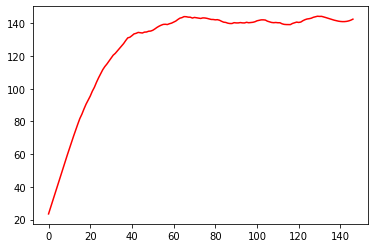

In [100]:
import numpy as np
from scipy.signal import savgol_filter
y = np.array(eval_list)
x = np.arange(len(y))
yhat = savgol_filter(y,31, 3) 

plt.plot(x, yhat, color='red')
plt.show()

# Identification policy

In [12]:
import gym
import gym_sin
import numpy as np
import time
from collections import deque
from gym import spaces
import torch


from ppo_a2c.model import Policy, MLPBase, ImprovedMLPBase
from ppo_a2c.algo.ppo import PPO
from ppo_a2c.storage import RolloutStorage
from ppo_a2c.envs import make_vec_envs_multi_task
from ppo_a2c.utils import get_vec_normalize
from ppo_a2c.envs import RewardSmoother, ObsSmoother, AdvancedRewardSmoother

In [13]:
inference_net = torch.load("inference_2")

In [25]:
# General parameters
device = "cpu"
env_name = "gauss-v0"
seed = 0
gamma = 0.99
log_dir = "."

# Training parameters
num_steps = 30
num_processes = 32

# PPO parametrs
clip_param = 0.2
ppo_epoch = 4
num_mini_batch = 8
value_loss_coef = 0.5
entropy_coef = 0.001
lr = 0.00005
eps = 1e-6
max_grad_norm=0.5

# Training parameters
use_linear_lr_decay = False
use_gae = False
gae_lambda = 0.95
use_proper_time_limits = False

# A2C
base = MLPBase
obs_shape = (8,) # state + latent space of the current model
action_space = spaces.Box(low=-1., high=1., shape=(1,), dtype="float")
actor_critic = Policy(obs_shape,
                      action_space, base=base,
                      base_kwargs={'recurrent':False,'hidden_size':32,'use_elu':False})

# PPO 
agent = PPO(actor_critic,
          clip_param,
          ppo_epoch,
          num_mini_batch,
          value_loss_coef,
          entropy_coef,
          lr=lr,
          eps=eps,
          max_grad_norm=max_grad_norm,
          use_clipped_value_loss=True)

# Reward log structure
episode_rewards = deque(maxlen=10)

In [26]:
def get_mse(p, t, latent_dim):
    if type(p) == list:
        p = torch.tensor([p[i].flatten().tolist() for i in range(num_processes)])
    return F.mse_loss(p[:, 0:latent_dim], t)

In [27]:
def get_reward(p, t, latent_dim):
    like = get_like(p, t, latent_dim)
    return like

In [28]:
def get_posterior(vi, action, reward, prior, prev_latent_space, use_prev_state=True):
    """
    Feed the variational model with the actual reward to identifiy the latent space
    and get the current reward using the posterior and the true task
    """
    num_proc = action.shape[0]
    prev_latent_space = torch.tensor(prev_latent_space)
    flatten_prior = torch.tensor([prior[i].flatten().tolist() for i in range(num_processes)])
    
    # To feed VI, i need (n_batch, 1, 2)
    context = torch.empty(num_proc, 1, 2)
    for i in range(num_proc):
        t = (100 - (-100))/(1 -(-1)) * (action[i] - 1) + 100
        context[i] = torch.cat([t, reward[i]])
    
    res = vi(context=context, prev_z=prev_latent_space, prior=flatten_prior, use_prev_state=use_prev_state)
    res = res[1:]
    res = torch.cat([res[0].detach(), res[1].detach()], 1)
    return res

In [29]:
def rescale_latent(num_proc, old_var, latent_dim):
    rescaled_latent = []
    
    max_old = [40, 35]
    min_old = [-40, 15]
    
    for i in range(num_proc):
        new = []
        for j in range(latent_dim):
            t = (1 - (-1)) / (max_old[j] - min_old[j]) * (old_var[i][j] - max_old[j]) + 1
            if t > 1:
                print("Exceeding max in latent dim {}".format(j))
                t = 1.
            elif t < -1:
                print("Exceeding min in latent dim {}".format(j))
                t = -1
            new.append(t)
        rescaled_latent.append(new)
    return rescaled_latent

def rescale_posterior(num_proc, old_var, latent_dim):
    rescaled_posterior = []
    
    max_old = [100, 50, 20, 20]
    min_old = [-100, 0, 0, 0]
    
    for i in range(num_proc):
        new = []
        for j in range(latent_dim * 2):
            t = (1 - (-1)) / (max_old[j] - min_old[j]) * (old_var[i][j] - max_old[j]) + 1
            if t > 1:
                print("Exceeding max in posterior dim {}, value {}, max {}".format(j, old_var[i][j], max_old[j]))
                t = 1.
            elif t < -1:
                print("Exceeding min in posterior dim {}, value {}, min {}".format(j,  old_var[i][j], min_old[j]))
                t = -1
            new.append(t)
        rescaled_posterior.append(new)
        
    return torch.tensor(rescaled_posterior)

In [19]:
def al_augment_obs(obs, prev_latent, latent_dim, env_obs_shape, posterior, prior,rescale_obs=True):
    num_proc = obs.shape[0]
    new_obs = torch.empty((num_proc, 4*latent_dim))
    
    prior = torch.tensor([prior[i].flatten().tolist() for i in range(num_processes)])
    
    if(type(posterior) == list):
        posterior = torch.tensor([posterior[i].flatten().tolist() for i in range(num_processes)])
    else:
        posterior[:, latent_dim:] = posterior[:, latent_dim:].exp()
    
    if rescale_obs:
        #prev_latent = rescale_latent(num_proc, prev_latent, latent_dim)
        posterior = rescale_posterior(num_proc, posterior, latent_dim)
        prior = rescale_posterior(num_proc, prior, latent_dim)
    
    for i in range(num_proc): 
        #new_obs[i] = torch.cat([obs[i], torch.Tensor(prev_latent[i]),posterior[i]])
        new_obs[i] = torch.cat([prior[i], posterior[i]])
    
    return new_obs

In [20]:
def get_like(posterior, offset_star, latent_dim):
    if type(posterior) == list:
        posterior = torch.tensor([posterior[i].flatten().tolist() for i in range(num_processes)])
        posterior[:, latent_dim:] = posterior[:, latent_dim:].log()
    
    l = torch.sum(-(1/(2*posterior[:, latent_dim:].exp()))*(posterior[:, 0:latent_dim]-offset_star).pow(2), 1).unsqueeze(1)  
    return l

def get_best_like(vi, num_proc, num_r, tasks, prior, prev_t, latent_dim, n_samples=30):
    # Retrieve tasks
    num_t = num_proc // num_r
    t = torch.empty((num_t, latent_dim))
    p = torch.empty((num_t, 2 * latent_dim))
    z = torch.empty((num_t, latent_dim))
    
    for i in range(num_t):
        t[i] = tasks[i * num_r].clone().detach()
        p[i] = prior[i * num_r].flatten().clone().detach()
        z[i] = torch.tensor([prev_t[i * num_r]])
    
    # Retrieve informative data
    context = torch.empty((num_t, n_samples, 2))
    for i in range(num_t):
        x_space = torch.arange(-100, 100, 0.01)
        f_space = torch.exp(-((x_space - t[i][0]) ** 2) / (t[i][1] ** 2))
        w = f_space / f_space.sum()
        temp = torch.multinomial(w, n_samples, replacement=True)
        x = x_space[temp]
        y = torch.exp(-((x-t[i,0])**2)/(t[i, 1]**2))
        context[i, :, 0] = x
        context[i, :, 1] = y
        
    # Compute posterior and likelihood
    res = vi(context=context, prior=p, prev_z=z)[1:]
    post = torch.empty((num_t, latent_dim * 2))
    for i in range(num_t):
        post[i] = torch.cat([res[0][i, :], res[1][i, :]])
    for i in range(num_t):
        p[i][latent_dim:] = p[i][latent_dim:].log()
    
    best = torch.empty((num_proc, 1))
    like_post = get_like(post, t, latent_dim)
    for i in range(num_t):
         for j in range(num_r):
                best[(i*num_r)+j] = like_post[i]
    
    return best.detach()

In [206]:
from functools import reduce

def fake_eval(actor_critic, vi, env_name, seed, num_processes, eval_log_dir, device,
                            num_task_to_evaluate, latent_dim, env_obs_shape, max_horizon=150):
    assert num_task_to_evaluate % num_processes == 0
    
    n_iter = num_task_to_evaluate // num_processes
    reward_iter = torch.zeros(num_processes, max_horizon)
    r_list = []
    mse_list_at_horizon = []
    mse_list_at_10 = []
    mse_list_at_50 = []
    mse_list_at_0 = []
    
    for _ in range(n_iter):
        # Choose pair of init task and distribution for the next task
        task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
        new_tasks = torch.tensor([param[i] for i in task_idx])

        prev_task_param = torch.randint(low=0, high=n_tasks, size=(num_processes,))

        prior = [prior_dist[prev_task_param[i]].clone().detach() for i in range(num_processes)]
        prev_task = torch.empty(num_processes, 2)

        mu = [prior[i][0].clone().detach() for i in range(num_processes)]
        var = [prior[i][1].clone().detach() for i in range(num_processes)]

        offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
        offset_param = torch.tensor(offset_param)

        prev_task = new_tasks - offset_param

        for i in range(num_processes):
            prior[i][0, :] = prev_task[i] + prior[i][0, :].clone().detach()

        prev_task = prev_task.tolist()
        mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]

        # Sample new task
        envs_kwargs = [{'amplitude':1, 
                        'mean':new_tasks[i][0].item(),
                        'std':new_tasks[i][1].item(),
                        'noise_std':0.001,
                        'scale_reward':False} for i in range(num_processes)]
        
        obs_rms_eval = ObsSmootherTemp(obs_shape=(7,))
        
        eval_envs = make_vec_envs_multi_task(env_name,
                                             seed, 
                                             num_processes,
                                             None,
                                             log_dir,
                                             device,
                                             False,
                                             envs_kwargs,
                                             num_frame_stack=None)

        obs = eval_envs.reset()
        obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, prior, prior)
        
        obs = obs_rms_eval.step(obs)
        
        epi_done = []

        eval_recurrent_hidden_states = torch.zeros(
            num_processes, actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(num_processes, 1, device=device)
        
        t=0 
        
        use_prev_state = False
        
        while len(epi_done) < num_processes:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=False)
            action = torch.empty((num_processes,1))
            
            for idx in range(num_processes):
                if t == 0:
                    action[idx] = torch.normal(mu[idx][0], mu[idx][1])
                else:
                    action[idx] = torch.normal(posterior[idx, 0], posterior[idx, 1])
            action = (1-(-1))/(100-(-100))*(action-100)+1

            # Obser reward and next obs
            if t == 0:
                mse_list_at_0.append(get_mse(prior, new_tasks, 2).item())
            
            obs, reward, done, infos = eval_envs.step(action)
            posterior = get_posterior(vi, action, reward, prior, prev_task, use_prev_state=use_prev_state)
            reward = get_reward(posterior, new_tasks, latent_dim)
            obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, posterior, prior)
            obs = obs_rms_eval.step(obs)
            use_prev_state = True
            reward_iter[:, t] = reward.squeeze()
            t = t+1
            
            if t == 10:
                mse_list_at_10.append(get_mse(posterior, new_tasks, 2).item())
            if t == 50:
                mse_list_at_50.append(get_mse(posterior, new_tasks, 2).item())
            
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)

            for info in infos:
                if 'episode' in info.keys():
                    epi_done.append(True)
            
        mse_list_at_horizon.append(get_mse(posterior, new_tasks, 2).item())
        r_list.append(reward_iter)
        eval_envs.close()
        
    mean_mse_0 = np.mean(mse_list_at_0)
    mean_mse_horizon = np.mean(mse_list_at_horizon)
    mean_mse_10 = np.mean(mse_list_at_10)
    mean_mse_50 = np.mean(mse_list_at_50)
    mean_r = np.mean(reduce(list.__add__, [torch.sum(elem, 1).tolist() for elem in r_list]))
    print("Evaluation using {} tasks. Mean reward: {}. Mean MSE: {:.2f} || {:.2f} || {:.2f} || {:.2f}".
          format(n_iter*num_processes, mean_r, mean_mse_0, mean_mse_10, mean_mse_50, mean_mse_horizon))
    return mean_r, r_list

In [30]:
from functools import reduce

def identification_evaluate(actor_critic, vi, env_name, seed, num_processes, eval_log_dir, device,
                            num_task_to_evaluate, latent_dim, env_obs_shape, max_horizon=150):
    assert num_task_to_evaluate % num_processes == 0
    
    n_iter = num_task_to_evaluate // num_processes
    reward_iter = torch.zeros(num_processes, max_horizon)
    r_list = []
    mse_list_at_horizon = []
    mse_list_at_10 = []
    mse_list_at_50 = []
    mse_list_at_0 = []
    
    for _ in range(n_iter):
        # Choose pair of init task and distribution for the next task
        task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
        new_tasks = torch.tensor([param[i] for i in task_idx])

        prev_task_param = torch.randint(low=0, high=n_tasks, size=(num_processes,))

        prior = [prior_dist[prev_task_param[i]].clone().detach() for i in range(num_processes)]
        prev_task = torch.empty(num_processes, 2)

        mu = [prior[i][0].clone().detach() for i in range(num_processes)]
        var = [prior[i][1].clone().detach() for i in range(num_processes)]

        offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
        offset_param = torch.tensor(offset_param)

        prev_task = new_tasks - offset_param

        for i in range(num_processes):
            prior[i][0, :] = prev_task[i] + prior[i][0, :].clone().detach()

        prev_task = prev_task.tolist()
        mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
        
        # Sample new task
        envs_kwargs = [{'amplitude':1, 
                        'mean':new_tasks[i][0].item(),
                        'std':new_tasks[i][1].item(),
                        'noise_std':0.001,
                        'scale_reward':False} for i in range(num_processes)]
        
        obs_rms_eval = ObsSmootherTemp(obs_shape=(7,))
        
        eval_envs = make_vec_envs_multi_task(env_name,
                                        seed, 
                                        num_processes,
                                        None,
                                        log_dir,
                                        device,
                                        False,
                                        envs_kwargs,
                                        num_frame_stack=None)

        obs = eval_envs.reset()
        obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, prior, prior)
        
        obs = obs_rms_eval.step(obs)
        
        epi_done = []

        eval_recurrent_hidden_states = torch.zeros(
            num_processes, actor_critic.recurrent_hidden_state_size, device=device)
        eval_masks = torch.zeros(num_processes, 1, device=device)
        
        t=0 
        
        use_prev_state = False
        while len(epi_done) < num_processes:
            with torch.no_grad():
                _, action, _, eval_recurrent_hidden_states = actor_critic.act(
                    obs,
                    eval_recurrent_hidden_states,
                    eval_masks,
                    deterministic=False)

            # Obser reward and next obs
            if t == 0:
                mse_list_at_0.append(get_mse(prior, new_tasks, 2).item())
            
            obs, reward, done, infos = eval_envs.step(action)
            posterior = get_posterior(vi, action, reward, prior, prev_task, use_prev_state=use_prev_state)
            reward = get_reward(posterior, new_tasks, latent_dim)
            obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, posterior, prior)
            obs = obs_rms_eval.step(obs)
            use_prev_state = True
            reward_iter[:, t] = reward.squeeze()
            t = t+1
            
            if t == 10:
                mse_list_at_10.append(get_mse(posterior, new_tasks, 2).item())
            if t == 50:
                mse_list_at_50.append(get_mse(posterior, new_tasks, 2).item())
            
            eval_masks = torch.tensor(
                [[0.0] if done_ else [1.0] for done_ in done],
                dtype=torch.float32,
                device=device)

            for info in infos:
                if 'episode' in info.keys():
                    epi_done.append(True)
            
        mse_list_at_horizon.append(get_mse(posterior, new_tasks, 2).item())
        r_list.append(reward_iter)
        eval_envs.close()
        
    mean_mse_0 = np.mean(mse_list_at_0)
    mean_mse_horizon = np.mean(mse_list_at_horizon)
    mean_mse_10 = np.mean(mse_list_at_10)
    mean_mse_50 = np.mean(mse_list_at_50)
    mean_r = np.mean(reduce(list.__add__, [torch.sum(elem, 1).tolist() for elem in r_list]))
    print("Evaluation using {} tasks. Mean reward: {}. Mean MSE: {:.2f} || {:.2f} || {:.2f} || {:.2f}".
          format(n_iter*num_processes, mean_r, mean_mse_0, mean_mse_10, mean_mse_50, mean_mse_horizon))
    return mean_r, r_list

In [54]:
start = time.time()

meta_training_iter = 100000
num_update_per_meta_training_iter = 1
num_task_to_evaluate = num_processes

latent_dim = 2
env_obs_shape = 1
obs_dim = 4

num_processes  = 32
log_interval = 5
eval_interval = 1
eval_list = []

variational_model = inference_net

for k in range(meta_training_iter):   
    # Choose pair of init task and distribution for the next task
    task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    new_tasks = torch.tensor([param[i] for i in task_idx])

    prev_task_param = torch.randint(low=0, high=n_tasks, size=(num_processes,))

    prior = [prior_dist[prev_task_param[i]].clone().detach() for i in range(num_processes)]
    prev_task = torch.empty(num_processes, 2)

    mu = [prior[i][0].clone().detach() for i in range(num_processes)]
    var = [prior[i][1].clone().detach() for i in range(num_processes)]

    offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
    offset_param = torch.tensor(offset_param)

    prev_task = new_tasks - offset_param

    for i in range(num_processes):
        prior[i][0, :] = prev_task[i] + prior[i][0, :].clone().detach()

    prev_task = prev_task.tolist()
    mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
    
    # Sample new task
    envs_kwargs = [{'amplitude':1, 
                    'mean':new_tasks[i][0].item(),
                    'std':new_tasks[i][1].item(),
                    'noise_std':0.001,
                    'scale_reward':False} for i in range(num_processes)]
    
    envs = make_vec_envs_multi_task(env_name,
                                    seed, 
                                    num_processes,
                                    None,
                                    log_dir,
                                    device,
                                    False,
                                    envs_kwargs,
                                    num_frame_stack=None)
    
    obs = envs.reset()
    obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, prior, prior)
    
    rollouts = RolloutStorage(num_steps, num_processes,
                              obs_shape, action_space,
                              actor_critic.recurrent_hidden_state_size)
    
    rollouts.obs[0].copy_(obs)
    rollouts.to(device)
    
    use_prev_state = False
    
    rms = FakeRewardSmoother()
    # rms = AdvancedRewardSmoother(num_processes, num_replicas, gamma=gamma)
    # rms = RewardSmoother(num_envs=num_processes, cliprew=10, gamma=gamma)
    obs_rms = ObsSmootherTemp(obs_shape=(7,))
    obs = obs_rms.step(obs)
    
    for _ in range(num_update_per_meta_training_iter):
        # Collect observations and store them into the storage
        for step in range(num_steps):
            # Sample actions
            with torch.no_grad():
                value, action, action_log_prob, recurrent_hidden_states = actor_critic.act(
                    rollouts.obs[step], rollouts.recurrent_hidden_states[step],
                    rollouts.masks[step])

            # Obser reward and next obs
            obs, reward, done, infos = envs.step(action)
            posterior = get_posterior(variational_model, action, reward, prior, prev_task, use_prev_state=use_prev_state)
            use_prev_state = True
            
            reward_prev = get_reward(posterior, new_tasks, latent_dim)
            reward = rms.step(reward_prev, done)
            obs = al_augment_obs(obs, prev_task, latent_dim, env_obs_shape, posterior, prior)
            obs = obs_rms.step(obs)
            
            # If done then clean the history of observations.
            if done.any():
                use_prev_state = False
            masks = torch.FloatTensor(
                [[0.0] if done_ else [1.0] for done_ in done])
            bad_masks = torch.FloatTensor(
                [[0.0] if 'bad_transition' in info.keys() else [1.0]
                 for info in infos])
            
            rollouts.insert(obs, recurrent_hidden_states, action,
                            action_log_prob, value, reward, masks, bad_masks)
     
        with torch.no_grad():
            next_value = actor_critic.get_value(
                rollouts.obs[-1], rollouts.recurrent_hidden_states[-1],
                rollouts.masks[-1]).detach()

        rollouts.compute_returns(next_value, use_gae, gamma,
                                 gae_lambda, use_proper_time_limits)

        value_loss, action_loss, dist_entropy = agent.update(rollouts)

        rollouts.after_update()
        
    rms.reset()
    eval_interval = 10
    if (eval_interval is not None and k % eval_interval == 0 and k>1):
        e = identification_evaluate(actor_critic, inference_net,env_name, seed, num_processes, ".", device,
                                    128, latent_dim, env_obs_shape)
        eval_list.append(e)

Evaluation using 128 tasks. Mean reward: -393.7668699771166. Mean MSE: 9.11 || 1.93 || 1.04 || 0.78
Evaluation using 128 tasks. Mean reward: -700.0639516115189. Mean MSE: 9.39 || 2.54 || 1.15 || 0.84
Evaluation using 128 tasks. Mean reward: -444.35441640019417. Mean MSE: 9.44 || 2.40 || 1.12 || 0.80
Evaluation using 128 tasks. Mean reward: -457.9572494328022. Mean MSE: 9.45 || 2.05 || 1.01 || 0.79
Evaluation using 128 tasks. Mean reward: -385.9866738319397. Mean MSE: 11.38 || 2.51 || 1.11 || 0.85
Evaluation using 128 tasks. Mean reward: -308.4610213637352. Mean MSE: 7.18 || 1.37 || 0.71 || 0.56
Evaluation using 128 tasks. Mean reward: -346.05783146619797. Mean MSE: 7.81 || 1.62 || 0.83 || 0.65
Evaluation using 128 tasks. Mean reward: -484.8431434035301. Mean MSE: 9.18 || 2.09 || 0.94 || 0.73
Evaluation using 128 tasks. Mean reward: -482.76983815431595. Mean MSE: 6.65 || 1.42 || 0.74 || 0.58
Evaluation using 128 tasks. Mean reward: -332.22653982043266. Mean MSE: 6.46 || 1.57 || 0.75 || 

KeyboardInterrupt: 

In [23]:
class FakeRewardSmoother:
    def __init__(self):
        pass

    def step(self, reward, done):
        return reward

    def reset(self):
        pass

In [24]:
from baselines.common.running_mean_std import RunningMeanStd

class ObsSmootherTemp:
    def __init__(self, obs_shape, clipob=10., epsilon=1e-8):
        self.clipob = clipob
        self.epsilon = epsilon
        self.ob_rms = RunningMeanStd(shape=obs_shape)

    def step(self, obs):
        return obs
        #obs = obs.numpy()
        #self.ob_rms.update(obs)
        #obs = np.clip((obs - self.ob_rms.mean) / np.sqrt(self.ob_rms.var + self.epsilon), -self.clipob, self.clipob)
        #return torch.tensor(obs, dtype=torch.float32)

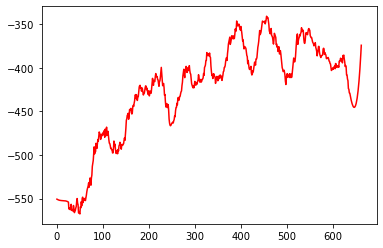

180


In [68]:
import numpy as np
from scipy.signal import savgol_filter

l = [eval_list[i][0] for i in range(len(eval_list))]

y = np.array(l)
x = np.arange(len(y))
yhat = savgol_filter(y, 51, 3) 

plt.plot(x, yhat, color='red')
#plt.plot(l)
plt.show()
print(k)

# VI behavior

In [18]:
def get_posterior_debug(variational_model, action, reward, prior, prev_latent_space, use_prev_state=True):
    """
    Feed the variational model with the actual reward to identifiy the latent space
    and get the current reward using the posterior and the true task
    """
    #prev_latent_space = torch.tensor(prev_latent_space)
    num_proc=1
    flatten_prior = torch.tensor([prior.flatten().tolist() for i in range(num_proc)])[0]
    
    # To feed VI, i need (n_batch, 1, 2)
    context = torch.empty(num_proc, 1, 2)
    for i in range(num_proc):
        context[i] = torch.cat([torch.tensor([action.item()]), torch.tensor([reward.item()])])
    
    posterior = variational_model(context=context, prev_z=prev_latent_space, prior=flatten_prior, use_prev_state=use_prev_state)
    posterior = posterior[1:]
    posterior = torch.cat([posterior[0].detach(), posterior[1].detach()], 1)
    return posterior

In [23]:
inference_net = torch.load("inference_2")

In [234]:
for _ in range(30):
    prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prev_task = [param[prev_task_idx[i]] for i in range(num_processes,)]

    prior_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prior = [prior_dist[prior_idx[i]].clone().detach() for i in range(num_processes)]

    # Sample current task from the prior 
    mu = [prior[i][0].clone().detach() for i in range(num_processes)]
    var = [prior[i][1].clone().detach() for i in range(num_processes)]

    offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
    offset_param = torch.tensor(offset_param)

    # Modify the prior
    for i in range(num_processes):
        prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

    mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
    new_tasks = offset_param + torch.tensor(prev_task)

    t = torch.tensor([prior[i].flatten().tolist() for i in range(32)])
    print("Prior loss {}".format(F.mse_loss(t[:, 0:2], new_tasks).item()))
    
    like_list = []
    final_loss = []
    for task in range(num_processes):
        curr_like = 0
        x = torch.normal(mean=torch.tensor([prior[task][0][0]]), std=torch.tensor([prior[task][0][1]]))
        y = torch.exp(-((x-new_tasks[task,0])**2)/(new_tasks[task, 1]**2))
        for s in range(150):
            use_prev_state = True if s > 0 else False
            posterior = get_posterior_debug(inference_net, x, y, prior[task], torch.tensor(prev_task[task]), use_prev_state=use_prev_state)
            if s == 10:
                final_loss.append(F.mse_loss(posterior[0][0:2], new_tasks[task]).item())
            l = torch.sum(-(1/(2*posterior[0, latent_dim:].exp()))*(posterior[0, 0:latent_dim]-new_tasks[task]).pow(2)) 
            curr_like += l
            x = torch.normal(mean=torch.tensor([posterior[0][0]]), std=torch.tensor([posterior[0][1]]))
            y = torch.exp(-((x-new_tasks[task,0])**2)/(new_tasks[task, 1]**2))
        like_list.append(curr_like)
    print("Reward {}".format(np.mean(like_list)))
    print("Final {}".format(np.mean(final_loss)))
    print("\n")

Prior loss 7.340719699859619
Reward -376.53363037109375
Final 1.5112009833101183


Prior loss 6.931302070617676
Reward -475.42034912109375
Final 2.13309088681126


Prior loss 8.667194366455078
Reward -460.37213134765625
Final 2.376362554728985


Prior loss 11.478805541992188
Reward -478.16851806640625
Final 2.4513191510923207


Prior loss 8.548314094543457
Reward -650.4971923828125
Final 3.062259681057185


Prior loss 13.514175415039062
Reward -1253.782958984375
Final 4.601800855831243


Prior loss 6.889156818389893
Reward -434.2346496582031
Final 1.8488404473755509


Prior loss 10.923748970031738
Reward -527.6890258789062
Final 2.018138045212254


Prior loss 6.158041954040527
Reward -437.3888244628906
Final 1.898487947655667


Prior loss 6.220515251159668


KeyboardInterrupt: 

In [251]:
offset_param + prev_task[0] - target[0]

tensor([0., 0.])

In [25]:
for _ in range(15):
    latent_dim = 2
    init_loss = []
    sum_reward = []
    final_loss = []
    
    for _ in range(32):
        # Choose pair of init task and distribution for the next task
        task_idx = torch.randint(low=0, high=n_tasks, size=(10,))
        prev_task = torch.tensor([param[i] for i in task_idx])

        prior_idx = torch.randint(low=0, high=n_tasks, size=(10,))
        
        prior = torch.empty(10, 4)
        for t_idx in range(10):
            prior[t_idx] = prior_dist[prior_idx[t_idx]].reshape(1, 4).squeeze(0)
        
        target = torch.empty(10, 2)
        
        mu = prior_dist[prior_idx[0]][0]
        var = prior_dist[prior_idx[0]][1]
        offset_param = torch.normal(mu, var)
        target[0] = prev_task[0] + offset_param 
        prior[0][0:2] = prev_task[0] + prior[0][0:2] 
        
        # Generate data 125
        x_space = torch.arange(-100, 100, 0.01)
        f_space = torch.exp(-((x_space - prior[0][0]) ** 2) / (prior[0][1] ** 2))
        w = f_space / f_space.sum()
        temp = torch.multinomial(w, 1, replacement=True)
        x = x_space[temp]
        y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))

        loss_list = []
        like_list = []
        loss_list.append(F.mse_loss(prior[0][0:2], target[0]).item())
        for s in range(150):
            use_prev_state = True if s > 0 else False
            posterior = get_posterior_debug(inference_net, x, y, prior[0], prev_task[0], use_prev_state=use_prev_state)
            loss_list.append(F.mse_loss(posterior[0][0:2], target[0]).item())
            l = torch.sum(-(1/(2*posterior[0, latent_dim:].exp()))*(posterior[0, 0:latent_dim]-target[0]).pow(2)) 
            like_list.append(l)
            x = torch.normal(mean=torch.tensor([posterior[0][0]]), std=torch.tensor([posterior[0][1]]))
            y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))
        
        sum_reward.append(np.sum(like_list))
        init_loss.append(loss_list[0])
        final_loss.append(loss_list[10])
    print("Avg sum reward {}".format(np.mean(sum_reward)))
    print("Avg init loss {}".format(np.mean(init_loss)))
    print("Avg fin loss {}\n".format(np.mean(final_loss)))

Avg sum reward -569.3123779296875
Avg init loss 10.58705666474998
Avg fin loss 2.459076871862635

Avg sum reward -561.9092407226562
Avg init loss 11.63562855613418
Avg fin loss 2.5571884110104293

Avg sum reward -364.62286376953125
Avg init loss 4.071773024450522
Avg fin loss 1.5416721549117938

Avg sum reward -631.57421875
Avg init loss 7.739219904877245
Avg fin loss 2.776363192660938

Avg sum reward -372.3067932128906
Avg init loss 7.485127763458877
Avg fin loss 1.6082890037214383

Avg sum reward -300.08135986328125
Avg init loss 6.846096712863073
Avg fin loss 1.6230857156333514

Avg sum reward -296.5817565917969
Avg init loss 6.846026549115777
Avg fin loss 1.4567715419107117

Avg sum reward -481.67962646484375
Avg init loss 7.864618497202173
Avg fin loss 2.4334596606495325

Avg sum reward -315.10009765625
Avg init loss 4.9444071072211955
Avg fin loss 1.2514138966798782

Avg sum reward -728.0061645507812
Avg init loss 9.433902491815388
Avg fin loss 2.8608156066620722

Avg sum reward 

In [211]:
for _ in range(15):
    init_loss = []
    sum_reward = []
    final_loss = []
    
    for _ in range(32):
        # Choose pair of init task and distribution for the next task
        task_idx = torch.randint(low=0, high=n_tasks, size=(10,))
        target = torch.tensor([param[i] for i in task_idx])

        prev_task_param = torch.randint(low=0, high=n_tasks, size=(10,))

        prior = torch.empty(10, 4)
        for t_idx in range(10):
            prior[t_idx] = prior_dist[prev_task_param[t_idx]].reshape(1, 4).squeeze(0)
        

        prev_task = torch.empty(10, 2)
        mu = prior_dist[prev_task_param[0]][0]
        var = prior_dist[prev_task_param[0]][1]

        offset_param = torch.normal(mu, var)

        prev_task[0] = target[0] - offset_param 
        prior[0][0:2] = prev_task[0] + prior[0][0:2] 

        # Generate data 125
        x_space = torch.arange(-100, 100, 0.01)
        #f_space = torch.exp(-((x_space - prior[0][0]) ** 2) / (prior[0][1] ** 2))
        #w = f_space / f_space.sum()
        #temp = torch.multinomial(w, 1, replacement=True)
        temp = torch.randint(low=0, high=x_space.shape[0],size=(1,))
        x = x_space[temp]
        y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))

        loss_list = []
        like_list = []
        loss_list.append(F.mse_loss(prior[0][0:2], target[0]).item())
        for s in range(150):
            use_prev_state = True if s > 0 else False
            posterior = get_posterior_debug(inference_net, x, y, prior[0], prev_task[0], use_prev_state=use_prev_state)
            loss_list.append(F.mse_loss(posterior[0][0:2], target[0]).item())
            l = torch.sum(-(1/(2*posterior[0, latent_dim:].exp()))*(posterior[0, 0:latent_dim]-target[0]).pow(2)) 
            like_list.append(l)
            x = torch.normal(mean=torch.tensor([posterior[0][0]]), std=torch.tensor([posterior[0][1]]))
            y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))
            #temp = torch.randint(low=0, high=x_space.shape[0],size=(1,))
            #x = x_space[temp]
            y = torch.exp(-((x-target[0,0])**2)/(target[0, 1]**2))

        sum_reward.append(np.sum(like_list))
        init_loss.append(loss_list[0])
        final_loss.append(loss_list[10])
    print("Avg sum reward {}".format(np.mean(sum_reward)))
    print("Avg init loss {}".format(np.mean(init_loss)))
    print("Avg fin loss {}".format(np.mean(final_loss)))
    print("\n")

Avg sum reward -271.3575134277344
Avg init loss 7.255287999054417
Avg fin loss 1.159103069046978


Avg sum reward -449.65643310546875
Avg init loss 11.527373017277569
Avg fin loss 2.506708252360113


Avg sum reward -280.9597473144531
Avg init loss 8.451346851477865
Avg fin loss 1.4670912814326584


Avg sum reward -386.91278076171875
Avg init loss 7.31937725370517
Avg fin loss 1.8360265843803063


Avg sum reward -420.3238525390625
Avg init loss 9.174345712177455
Avg fin loss 2.0776532328454778


Avg sum reward -473.8013000488281
Avg init loss 10.1648808530299
Avg fin loss 2.0735176417510957


Avg sum reward -314.5928955078125
Avg init loss 6.372849454637617
Avg fin loss 1.3896513283834793


Avg sum reward -450.01715087890625
Avg init loss 12.170947121456265
Avg fin loss 1.9375369109911844


Avg sum reward -378.7605895996094
Avg init loss 7.8079616776667535
Avg fin loss 1.8007244491600432


Avg sum reward -419.80694580078125
Avg init loss 9.695794148836285
Avg fin loss 1.9498640805541072

Avg init loss 7.1185324266552925
Avg fin loss 2.1012035674694927


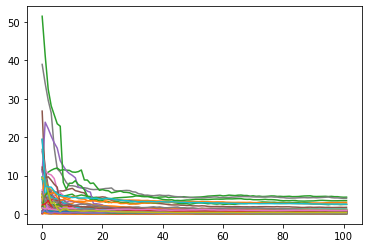

In [45]:
init_loss = []
final_loss = []
num_processes=4
for i in range(50):
    # Sample previous task and prior distribution on the next task
    prev_task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prev_task = [param[prev_task_idx[i]] for i in range(num_processes,)]

    prior_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
    prior = [prior_dist[prior_idx[i]].clone().detach() for i in range(num_processes)]

    # Sample current task from the prior 
    mu = [prior[i][0].clone().detach() for i in range(num_processes)]
    var = [prior[i][1].clone().detach() for i in range(num_processes)]

    offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
    offset_param = torch.tensor(offset_param)

    # Modify the prior
    for i in range(num_processes):
        prior[i][0, :] = prior[i][0, :] + torch.tensor(prev_task[i])

    mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]
    new_tasks = offset_param + torch.tensor(prev_task)    

    # Generate data 125
    x_space = torch.arange(-100, 100, 0.01)
    f_space = torch.exp(-((x_space - new_tasks[0][0]) ** 2) / (new_tasks[0][1] ** 2))
    w = f_space / f_space.sum()
    temp = torch.multinomial(w, 1000, replacement=True)
    #temp = torch.randint(low=0, high=x_space.shape[0],size=(101,))
    x = x_space[temp]
    y = torch.exp(-((x-new_tasks[0,0])**2)/(new_tasks[0, 1]**2))

    loss_list = []
    loss_list.append(F.mse_loss(prior[0][0, 0:2], new_tasks[0]).item())
    for i in range(101):
        use_prev_state = True if i > 0 else False
        posterior = get_posterior_debug(inference_net, x[i], y[i], prior[0], torch.tensor(prev_task[0]), use_prev_state=use_prev_state)
        loss_list.append(F.mse_loss(posterior[0][0:2], new_tasks[0]).item())
        if i == 20 and loss_list[-1] > 20:
            print(offset_param[0])
        #if i == 100 or i == 1:
        #    print("Posterior var {}".format(posterior[0][2:].exp()))

    plt.plot(loss_list)
    #print(loss_list[0])
    #print(loss_list[-1])
    init_loss.append(loss_list[0])
    final_loss.append(loss_list[10])
print("Avg init loss {}".format(np.mean(init_loss)))
print("Avg fin loss {}".format(np.mean(final_loss)))

In [ ]:
torch.save(actor_critic, "identification_policy")
torch.save(actor_critic_multi_task, "multi_task_policy")

# Selection meta-policy

Here, we want to meta-train a policy to choose when we should explore and start exploring.
Ideas:
- It should a policy that output 1 and 0? How should we train something like that? What should the loss be? Somehow it would be related to the per-episode reward... However, the best the we can do somehow depends on the all the task evolution... but we do not know that...

Baselines:
- POSTERIOR and MULTI-TASK: A meta-optimal policy that selects the action on the basis of the posterior. This is really easy to evaluate: just take multi-task policy and use VAE
- ORACLE: a policy who knows the exact task parameters at each timestep
- FIXED-IDENTIFICATION: stop identifying after a fixed number of samples. We can study for instance how many samples do we need to go beyond a certain MSE error. However, this somehow depends on the prior. The naive thing is a fixed number, however, we could do better: the number to get below the MSE error depend on the prior distribution... How can we train something like that? It should be a classification network that given the posterior, the prior and the number of query of the policy, outputs 1 if we should or not stop the search.

# Fixed identification

In [121]:
new_net = InferenceNetwork2(n_in=8,z_dim=2)
optimizer = torch.optim.Adam(inference_net.parameters())

In [140]:
# Choose pair of init task and distribution for the next task
task_idx = torch.randint(low=0, high=n_tasks, size=(num_processes,))
new_tasks = torch.tensor([param[i] for i in task_idx])

prev_task_param = torch.randint(low=0, high=n_tasks, size=(num_processes,))

prior = [prior_dist[prev_task_param[i]].clone().detach() for i in range(num_processes)]
prev_task = torch.empty(num_processes, 2)

mu = [prior[i][0].clone().detach() for i in range(num_processes)]
var = [prior[i][1].clone().detach() for i in range(num_processes)]

offset_param = [torch.normal(mu[i], var[i]).tolist() for i in range(num_processes)]
offset_param = torch.tensor(offset_param)

prev_task = new_tasks - offset_param

for i in range(num_processes):
    prior[i][0, :] = prev_task[i] + prior[i][0, :].clone().detach()

prev_task = prev_task.tolist()
mu = [mu[i] + torch.tensor(prev_task[i]) for i in range(num_processes)]

# Sample new task
envs_kwargs = [{'amplitude':1, 
                'mean':new_tasks[i][0].item(),
                'std':new_tasks[i][1].item(),
                'noise_std':0.001,
                'scale_reward':False} for i in range(num_processes)]

envs = make_vec_envs_multi_task(env_name,
                                seed, 
                                num_processes,
                                None,
                                log_dir,
                                device,
                                False,
                                envs_kwargs,
                                num_frame_stack=None)

In [135]:
min_seq_len = 1
max_seq_len = 150
num_vae_steps = 1

In [136]:
n_batch = 32
prior = torch.empty(n_batch, 4)
mu_prior = torch.empty(n_batch, 2)
logvar_prior = torch.empty(n_batch, 2)
for t_idx in range(n_batch):
    prior[t_idx] = prior_dist[prev_task_param[t_idx]].reshape(1, 4).squeeze(0).clone().detach()
    mu_prior[t_idx] = prior_dist[prev_task_param[t_idx]][0].clone().detach()
    logvar_prior[t_idx] = prior_dist[prev_task_param[t_idx]][1].clone().detach().log()

In [137]:
for k in range(num_vae_steps):
    num_data_context = torch.randint(low=min_seq_len, high=max_seq_len, size=(1,)).item()
    idx = torch.randperm(max_seq_len)
    ctx_idx = idx[0:num_data_context]

    context = torch.empty(n_batch, num_data_context, 2)
    prev_task = torch.empty(n_batch, 2)
    
    for t_idx in range(n_batch):
        # Creating new task
        mu = prior_dist[prev_task_param[t_idx]][0].clone().detach()
        var = prior_dist[prev_task_param[t_idx]][1].clone().detach()

        offset_param = torch.normal(mu, var)
        prev_task[t_idx] = new_tasks[i] - offset_param
        prior[t_idx][0:2] = prev_task[t_idx] + prior[t_idx][0:2].clone().detach()
        mu_prior[t_idx] = prev_task[t_idx] + mu_prior[t_idx].clone().detach()
    
    obs = envs.reset()
    
    for _ in range(num_data_context):
        
        _, action, _, recurrent_hidden_states = actor_critic.act(
                        obs,
                        recurrent_hidden_states,
                        masks,
                        deterministic=True)

        # Creating context to be fed to the network
        #batch = task[k]['train']
        #batch = torch.cat([batch[0], batch[1]], dim=1)
        #context[i] = batch[ctx_idx]
        


RuntimeError: size mismatch, m1: [32 x 1], m2: [8 x 32] at C:\w\1\s\tmp_conda_3.7_100118\conda\conda-bld\pytorch_1579082551706\work\aten\src\TH/generic/THTensorMath.cpp:136

In [138]:
obs

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [141]:
envs.reset()

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [143]:
action = torch.zeros(32, 1)
envs.step(action)
envs.reset()

RuntimeError: Tried to reset an environment before done. If you want to allow early resets, wrap your env with Monitor(env, path, allow_early_resets=True)

In [145]:
mu_hat = torch.tensor(([[-4.5736, -5.6167],
        [-4.5995, -5.5584],
        [-4.5447, -5.6031],
        [-4.5297, -5.5113],
        [-4.6044, -5.5776],
        [-4.5590, -5.6067],
        [-4.5123, -5.5357],
        [-4.5706, -5.5982],
        [-4.5858, -5.5714],
        [-4.5625, -5.5824],
        [-4.4981, -5.4977],
        [-4.5742, -5.5858],
        [-4.5905, -5.5652],
        [-4.5940, -5.5453],
        [-4.5768, -5.5583],
        [-4.6133, -5.5942],
        [-4.5947, -5.5796],
        [-4.5960, -5.5496],
        [-4.5939, -5.5749],
        [-4.5499, -5.5939],
        [-4.5859, -5.5737],
        [-4.6060, -5.5917],
        [-4.5622, -5.5881],
        [-4.5937, -5.5275],
        [-4.5483, -5.5648],
        [-4.5279, -5.5324],
        [-4.5729, -5.5762],
        [-4.5582, -5.5640],
        [-4.5754, -5.5296],
        [-4.5762, -5.5990],
        [-4.6007, -5.5767],
        [-4.5499, -5.5863]]))

In [148]:
logvar_hat = torch.tensor(([[-2.7202,  3.5733],
        [-2.7427,  3.5949],
        [-2.7453,  3.4146],
        [-2.7562,  3.6051],
        [-2.6888,  3.6820],
        [-2.7102,  3.5139],
        [-2.6849,  3.5726],
        [-2.7284,  3.6229],
        [-2.7323,  3.5869],
        [-2.7436,  3.5241],
        [-2.7217,  3.6121],
        [-2.7509,  3.6344],
        [-2.7200,  3.5609],
        [-2.7387,  3.5669],
        [-2.7256,  3.6080],
        [-2.7027,  3.6222],
        [-2.7467,  3.5562],
        [-2.7350,  3.6479],
        [-2.7684,  3.5777],
        [-2.7411,  3.4838],
        [-2.7227,  3.5752],
        [-2.7380,  3.6019],
        [-2.7510,  3.5215],
        [-2.7348,  3.6059],
        [-2.7772,  3.5317],
        [-2.6809,  3.5654],
        [-2.7414,  3.5932],
        [-2.6938,  3.5981],
        [-2.7203,  3.5340],
        [-2.7988,  3.5107],
        [-2.6951,  3.5948],
        [-2.7277,  3.4164]]))
z = torch.tensor(([[ 6.7558e-01,  2.2573e+01],
        [-2.7218e-02,  2.6196e+01],
        [-3.7066e+01,  2.3923e+01],
        [-3.6919e+01,  1.6424e+01],
        [ 9.4472e+00,  2.4021e+01],
        [ 1.6121e+00,  3.0990e+01],
        [-2.4685e+01,  1.8533e+01],
        [ 7.9599e-01,  2.1005e+01],
        [ 9.6045e+00,  2.8377e+01],
        [ 1.0271e+01,  2.6835e+01],
        [-2.2725e+01,  2.2635e+01],
        [ 3.5228e+01,  2.3419e+01],
        [-6.1438e+00,  1.9029e+01],
        [-2.9312e+00,  2.2424e+01],
        [ 4.6941e+00,  1.5226e+01],
        [ 2.0995e+01,  3.4946e+01],
        [ 1.7635e+01,  2.7040e+01],
        [ 1.3886e+01,  1.7287e+01],
        [ 3.0028e+01,  3.4110e+01],
        [ 3.2592e+00,  1.9136e+01],
        [ 2.4801e+00,  2.8218e+01],
        [ 3.1573e+01,  2.8707e+01],
        [ 1.5901e+01,  3.0177e+01],
        [-2.1286e+00,  2.7334e+01],
        [-2.0234e+01,  3.3972e+01],
        [-3.0675e+01,  2.5438e+01],
        [ 1.7635e+01,  2.7040e+01],
        [-1.4248e+01,  3.2116e+01],
        [ 5.7589e+00,  1.7996e+01],
        [ 1.2729e+01,  2.3523e+01],
        [-8.5331e+00,  2.6929e+01],
        [-6.0825e+00,  3.3631e+01]]))


In [158]:
mse = torch.mean(torch.sum(logvar_hat.exp(), 1)) + F.mse_loss(mu_hat, z)

In [155]:
torch.mean(torch.sum(logvar_hat.exp(),1))

tensor(35.6061)

In [159]:
mse.item()

709.6632080078125